# Baseline

MAE: 2577.58
rmse: 5257.72
mdae: 1210.75


# Model

Using device: cuda
Step 0, ELBO/pt = 6873.4367
Step 200, ELBO/pt = 3171.4353
Step 400, ELBO/pt = 1930.5124
Step 600, ELBO/pt = 1800.4122
Step 800, ELBO/pt = 1732.4188
Step 1000, ELBO/pt = 1749.8999
Step 1200, ELBO/pt = 1712.6702
Step 1400, ELBO/pt = 1702.6884
Step 1600, ELBO/pt = 1696.0460
Step 1800, ELBO/pt = 1693.0801
Step 2000, ELBO/pt = 1694.1384
Step 2200, ELBO/pt = 1692.8091
Step 2400, ELBO/pt = 1693.1906
Step 2600, ELBO/pt = 1692.4383
Step 2800, ELBO/pt = 1692.2726
Step 3000, ELBO/pt = 1691.8012
Step 3200, ELBO/pt = 1691.8495
Step 3400, ELBO/pt = 1692.2961
Step 3600, ELBO/pt = 1691.3895
Step 3800, ELBO/pt = 1691.3593


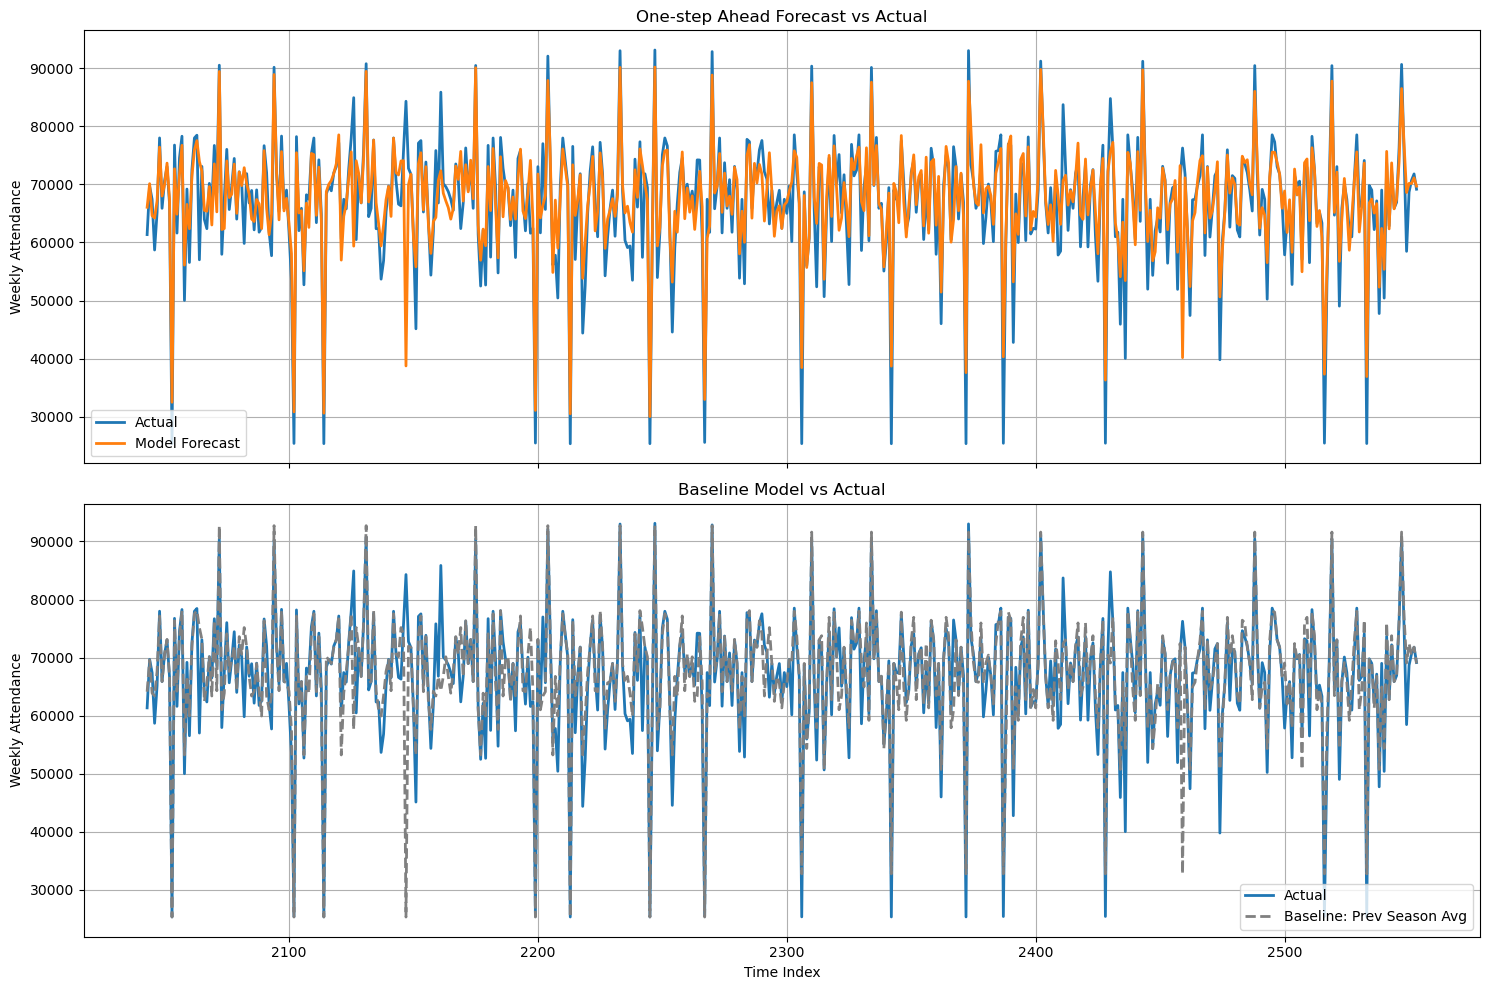

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from pyro.optim import ClippedAdam
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Load and clean the data
df = pd.read_csv("../processed_data/games_filtered.csv")
features = [
    "away_team_superbowl_winner_last_season",
    "home_team_playoffs_last_season",
    "away_team_playoffs_last_season",
    "home_team_wins_last_3",
    "away_team_wins_last_3",
    'pts_home','pts_away','yds_home','yds_away',
    'turnovers_home','turnovers_away',
    'zscore_pts_home','zscore_yds_home','zscore_turnovers_home',
    'zscore_pts_away','zscore_yds_away','zscore_turnovers_away',
    'day_sin','day_cos','month_sin','month_cos',
    'noon','mid_afternoon','late_afternoon','evening'
]
# Drop any rows with missing values in the required columns
df = df.dropna(subset=features + [
    "avg_season_attendance_prev",
    "prev_game_attendance",
    "weekly_attendance"
])

# Fit StandardScalers to each set of columns
scaler_x    = StandardScaler().fit(df[features])
scaler_avg  = StandardScaler().fit(df[["avg_season_attendance_prev"]])
scaler_prev = StandardScaler().fit(df[["prev_game_attendance"]])
scaler_y    = StandardScaler().fit(df[["weekly_attendance"]])

# Transform to tensors (will move to GPU if available later)
x_all    = torch.tensor(scaler_x.transform(df[features]), dtype=torch.float32)
avg_all  = torch.tensor(scaler_avg.transform(df[["avg_season_attendance_prev"]])[:,0],
                        dtype=torch.float32)
prev_all = torch.tensor(scaler_prev.transform(df[["prev_game_attendance"]])[:,0],
                        dtype=torch.float32)
y_all    = torch.tensor(scaler_y.transform(df[["weekly_attendance"]])[:,0],
                        dtype=torch.float32)

# Split into training and test sets (80/20)
N     = y_all.size(0)
split = int(0.8 * N)
x_train, x_test       = x_all[:split],    x_all[split:]
avg_train, avg_test   = avg_all[:split],  avg_all[split:]
prev_train, prev_test = prev_all[:split], prev_all[split:]
y_train, y_test       = y_all[:split],    y_all[split:]

# Select device better works on DTU HPU training is very slow otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Move training tensors to the chosen device
x_train   = x_train.to(device)
avg_train = avg_train.to(device)
prev_train= prev_train.to(device)
y_train   = y_train.to(device)

# Define the state-space model in PyroModule
class AttendanceModel(PyroModule):
    def __init__(self, num_features, seq_len):
        super().__init__()
        self.num_features = num_features
        self.seq_len      = seq_len

    def model(self, obs, feat, avg, prev):
        """
        obs:      Tensor of shape (T,) containing observed attendances
        feat:     Tensor of shape (T, F) of game-related covariates
        avg:      Tensor of shape (T,) of season-average attendance
        prev:     Tensor of shape (T,) of previous-game attendance
        """
        dev = obs.device

        # Hierarchical half-Cauchy prior for noise scales
        sigma0     = pyro.sample("sigma0",     dist.HalfCauchy(torch.tensor(5.0, device=dev)))
        proc_noise = pyro.sample("proc_noise", dist.HalfCauchy(sigma0))
        meas_noise = pyro.sample("meas_noise", dist.HalfCauchy(sigma0))

        # Intercept prior
        intercept = pyro.sample(
            "intercept",
            dist.Normal(torch.tensor(0.0, device=dev), torch.tensor(10.0, device=dev))
        )

        # AR(1) coefficient constrained to [-1, 1] via a Beta→linear transform
        raw_ar   = pyro.sample("raw_ar", dist.Beta(2.0, 2.0))
        ar_coef  = 2.0 * raw_ar - 1.0

        # Season-average effect prior (tight Normal around 1.0)
        avg_coef = pyro.sample("avg_coef", dist.Normal(1.0, 0.1))

        # Feature coefficients with Laplace (double-exponential) shrinkage
        feat_coefs = pyro.sample(
            "feat_coefs",
            dist.Laplace(loc=torch.zeros(self.num_features, device=dev),
                         scale=torch.tensor(1.0, device=dev))
            .to_event(1)
        )

        # Build latent means vector mu_z for each time step
        # We start latent state with the previous-game attendance
        z0     = prev[:1]
        z_prev = torch.cat([z0, torch.zeros(self.seq_len - 1, device=dev)])
        mu_z   = (
            intercept
            + ar_coef * z_prev
            + avg_coef * avg
            + (feat * feat_coefs).sum(-1)
        )

        # Sample latent states and observations in parallel over time
        with pyro.plate("time", self.seq_len):
            z = pyro.sample("z", dist.Normal(mu_z, proc_noise).to_event(1))
            pyro.sample("y", dist.Normal(z, meas_noise).to_event(1), obs=obs)

# Instantiate and run SVI(tried from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps, not working)
model = AttendanceModel(x_train.size(1), x_train.size(0)).to(device) # Move model to device
guide = AutoNormal(model.model) # Auto guide for variational inference
optim = ClippedAdam({"lr": 0.005, "clip_norm": 5.0})
svi   = SVI(model.model, guide, optim, loss=Trace_ELBO()) # Set up SVI with Trace_ELBO loss

for step in range(4000):
    loss = svi.step(y_train, x_train, avg_train, prev_train)
    if step % 200 == 0:
        print(f"Step {step:4d}  ELBO per point = {loss / y_train.size(0):.4f}")

# Extract posterior medians for parameters
q            = guide.quantiles([0.5]) # Get posterior quantiles
intercept_pt = q["intercept"][0].cpu() # Extract intercept
ar_coef_pt   = (2 * q["raw_ar"][0] - 1.0).cpu() # Transform raw AR coefficient to [-1, 1] range
avg_coef_pt  = q["avg_coef"][0].cpu() # Extract average coefficient
feat_coefs_pt= q["feat_coefs"].cpu() # Extract feature coefficients

# One-step-ahead forecasting on the test set (CPU)
x_test_cpu      = x_test
avg_test_cpu    = avg_test
prev_train_cpu  = prev_train.cpu()
test_len        = y_test.size(0)

z_prev = prev_train_cpu[-1].unsqueeze(0)
y_preds = []
for t in range(test_len):
    mu = (
        intercept_pt
        + ar_coef_pt * z_prev[-1]
        + avg_coef_pt * avg_test_cpu[t]
        + (feat_coefs_pt * x_test_cpu[t]).sum()
    )
    z_prev = torch.cat([z_prev, mu.unsqueeze(0)], dim=0)
    y_preds.append(mu)

y_preds     = torch.stack(y_preds).numpy()
y_pred_orig = scaler_y.inverse_transform(y_preds.reshape(-1,1))[:,0] # Inverse transform(strandarization) to original scale
actual_orig = scaler_y.inverse_transform(y_test.numpy().reshape(-1,1))[:,0] # Inverse transform(strandarization) to original scale

# Plot the model forecast vs. actual, and baseline vs. actual
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# visualize the one-step-ahead forecast vs. actual
axes[0].plot(range(split, N), actual_orig,   label="Actual",         linewidth=2)
axes[0].plot(range(split, N), y_pred_orig,   label="Model Forecast", linewidth=2)
axes[0].set_ylabel("Weekly Attendance")
axes[0].set_title("One-step Ahead Forecast vs Actual")
axes[0].legend()
axes[0].grid(True)

# visualize the baseline model vs. actual
baseline = df["avg_season_attendance_prev"].values[split:N]
axes[1].plot(range(split, N), actual_orig,  label="Actual",                   linewidth=2)
axes[1].plot(range(split, N), baseline,    label="Baseline: Prev Season Avg", linestyle="--", color="gray", linewidth=2)
axes[1].set_xlabel("Time Index")
axes[1].set_ylabel("Weekly Attendance")
axes[1].set_title("Baseline Model vs Actual")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
print(mean_absolute_error(y_pred_orig, actual_orig))
print(mean_squared_error(y_pred_orig, actual_orig, squared=False))
print(np.median(np.abs(y_pred_orig-actual_orig)))

3149.9016
5090.9985
1978.7422


## Baseline

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual_orig, df["avg_season_attendance_prev"][split:])
rmse = mean_squared_error(actual_orig, df["avg_season_attendance_prev"][split:], squared=False)
mdae = np.median(np.abs(actual_orig - df["avg_season_attendance_prev"][split:]))

print(f"MAE: {mae:.2f}")
print(f"rmse: {rmse:.2f}")
print(f"mdae: {mdae:.2f}")

MAE: 2577.58
rmse: 5257.72
mdae: 1210.75
